In [ ]:
import numpy as np
from numpy import random

def correlated_noise_surrogates(original_data):
    """
    Return Fourier surrogates.

    Generate surrogates by Fourier transforming the :attr:`original_data`
    time series (assumed to be real valued), randomizing the phases and
    then applying an inverse Fourier transform. Correlated noise surrogates
    share their power spectrum and autocorrelation function with the
    original_data time series.

    The Fast Fourier transforms of all time series are cached to facilitate
    a faster generation of several surrogates for each time series. Hence,
    :meth:`clear_cache` has to be called before generating surrogates from
    a different set of time series!

    .. note::
        The amplitudes are not adjusted here, i.e., the
        individual amplitude distributions are not conserved!

    **Examples:**

    The power spectrum is conserved up to small numerical deviations:

    >>> ts = Surrogates.SmallTestData().original_data
    >>> surrogates = Surrogates.\
            SmallTestData().correlated_noise_surrogates(ts)
    >>> all(r(np.abs(np.fft.fft(ts,         axis=1))[0,1:10]) == \
            r(np.abs(np.fft.fft(surrogates, axis=1))[0,1:10]))
    True

    However, the time series amplitude distributions differ:

    >>> all(np.histogram(ts[0,:])[0] == np.histogram(surrogates[0,:])[0])
    False

    :type original_data: 2D array [index, time]
    :arg original_data: The original time series.
    :rtype: 2D array [index, time]
    :return: The surrogate time series.
    """

    #  Calculate FFT of original_data time series
    #  The FFT of the original_data data has to be calculated only once,
    #  so it is stored in self._original_data_fft.
    surrogates = np.fft.rfft(original_data, axis=1)

    #  Get shapes
    (N, n_time) = original_data.shape
    len_phase = surrogates.shape[1]

    #  Generate random phases uniformly distributed in the
    #  interval [0, 2*Pi]
    phases = random.uniform(low=0, high=2 * np.pi, size=(N, len_phase))

    #  Add random phases uniformly distributed in the interval [0, 2*Pi]
    surrogates *= np.exp(1j * phases)

    #  Calculate IFFT and take the real part, the remaining imaginary part
    #  is due to numerical errors.
    return np.ascontiguousarray(np.real(np.fft.irfft(surrogates, n=n_time,
                                                        axis=1)))

def AAFT_surrogates(original_data):
    """
    Return surrogates using the amplitude adjusted Fourier transform
    method.

    Reference: [Schreiber2000]_

    :type original_data: 2D array [index, time]
    :arg original_data: The original time series.
    :rtype: 2D array [index, time]
    :return: The surrogate time series.
    """
    #  Create sorted Gaussian reference series
    gaussian = random.randn(original_data.shape[0], original_data.shape[1])
    gaussian.sort(axis=1)

    #  Rescale data to Gaussian distribution
    ranks = original_data.argsort(axis=1).argsort(axis=1)
    rescaled_data = np.zeros(original_data.shape)

    for i in range(original_data.shape[0]):
        rescaled_data[i, :] = gaussian[i, ranks[i, :]]

    #  Phase randomize rescaled data
    phase_randomized_data = correlated_noise_surrogates(rescaled_data)

    #  Rescale back to amplitude distribution of original data
    sorted_original = original_data.copy()
    sorted_original.sort(axis=1)

    ranks = phase_randomized_data.argsort(axis=1).argsort(axis=1)

    for i in range(original_data.shape[0]):
        rescaled_data[i, :] = sorted_original[i, ranks[i, :]]

    return rescaled_data


def refined_AAFT_surrogates(original_data, n_iterations, output="true_amplitudes"):
    """
    Return surrogates using the iteratively refined amplitude adjusted
    Fourier transform method.

    A set of AAFT surrogates (:meth:`AAFT_surrogates`) is iteratively
    refined to produce a closer match of both amplitude distribution and
    power spectrum of surrogate and original data.

    Reference: [Schreiber2000]_

    :type original_data: 2D array [index, time]
    :arg original_data: The original time series.
    :arg int n_iterations: Number of iterations / refinement steps
    :arg str output: Type of surrogate to return. "true_amplitudes":
        surrogates with correct amplitude distribution, "true_spectrum":
        surrogates with correct power spectrum, "both": return both outputs
        of the algorithm.
    :rtype: 2D array [index, time]
    :return: The surrogate time series.
    """
    #  Get size of dimensions
    n_time = original_data.shape[1]

    #  Get Fourier transform of original data with caching
    fourier_transform = np.fft.rfft(original_data, axis=1)

    #  Get Fourier amplitudes
    original_fourier_amps = np.abs(fourier_transform)

    #  Get sorted copy of original data
    sorted_original = original_data.copy()
    sorted_original.sort(axis=1)

    #  Get starting point / initial conditions for R surrogates
    # (see [Schreiber2000]_)
    R = AAFT_surrogates(original_data)

    #  Start iteration
    for i in range(n_iterations):
        #  Get Fourier phases of R surrogate
        r_fft = np.fft.rfft(R, axis=1)
        r_phases = r_fft / np.abs(r_fft)

        #  Transform back, replacing the actual amplitudes by the desired
        #  ones, but keeping the phases exp(iψ(i)
        s = np.fft.irfft(original_fourier_amps * r_phases, n=n_time,
                            axis=1)

        #  Rescale to desired amplitude distribution
        ranks = s.argsort(axis=1).argsort(axis=1)

        for j in range(original_data.shape[0]):
            R[j, :] = sorted_original[j, ranks[j, :]]

    if output == "true_amplitudes":
        return R
    elif output == "true_spectrum":
        return s
    elif output == "both":
        return (R, s)
    else:
        return (R, s)

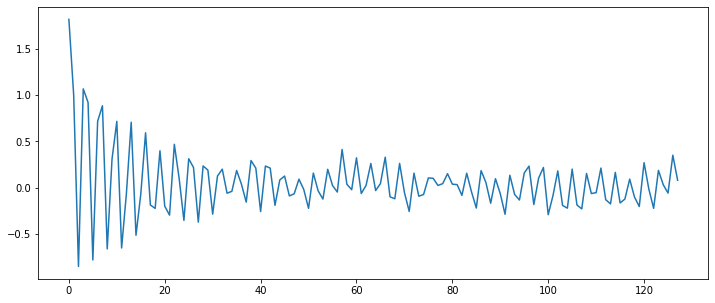

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predefined paramters
ar_n = 3                     # Order of the AR(n) data
ar_coeff = [0.7, -0.3, -0.1] # Coefficients b_3, b_2, b_1
noise_level = 0.1            # Noise added to the AR(n) data
length = 128                 # Number of data points to generate

# Random initial values
ar_data = list(np.random.randn(ar_n))

# Generate the rest of the values
for i in range(length - ar_n):
    next_val = (np.array(ar_coeff) @ np.array(ar_data[-3:])) + np.random.randn() * noise_level
    ar_data.append(next_val)

# Plot the time series
fig = plt.figure(figsize=(12,5))
plt.plot(ar_data)
plt.show()

original_data = np.asarray(ar_data).copy().squeeze()
ar_data = np.asarray(ar_data).reshape(1,-1)


In [ ]:
# !pip install pyunicorn
# import pylab
# from pyunicorn.timeseries import surrogates
# surro = surrogates.Surrogates(ar_data)
# surrogated_data = surro.refined_AAFT_surrogates(ar_data,n_iterations=1000,output='true_spectrum')

In [ ]:
surrogated_data = refined_AAFT_surrogates(ar_data,n_iterations=1000,output='true_spectrum')

surrogated_data = surrogated_data.reshape(-1,1).squeeze()

proportion = 0.85
sum_data = (proportion)*original_data + (1-proportion)*surrogated_data

[]

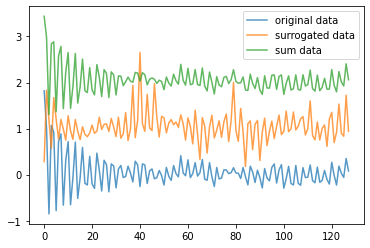

In [ ]:
plt.plot(original_data, alpha=0.75, label='original data')
plt.plot(surrogated_data+1, alpha=0.75, label='surrogated data')
plt.plot(sum_data+2, alpha=0.75, label='sum data')
plt.legend()
plt.plot()

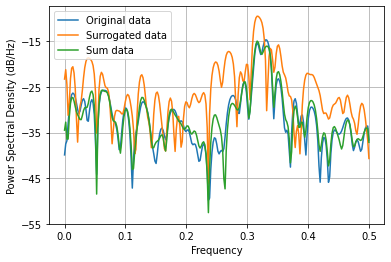

In [ ]:
plt.psd(original_data, 512, 1, label='Original data')
plt.psd(surrogated_data, 512, 1, label='Surrogated data')
plt.psd(sum_data, 512, 1, label='Sum data')
plt.legend()
plt.show()

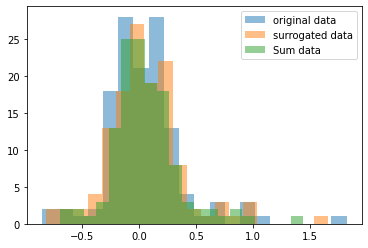

In [ ]:
plt.hist(original_data,bins=20, alpha=0.5, label='original data')
plt.hist(surrogated_data,bins=20, alpha=0.5, label='surrogated data')
plt.hist(sum_data,bins=20, alpha=0.5, label='Sum data')
plt.legend()
plt.show()

In [ ]:
np.std(sum_data)

0.2954392003173895

In [ ]:
np.std(original_data)

0.34247627503603273

In [ ]:
np.std(surrogated_data)

0.34247627503603273

[]

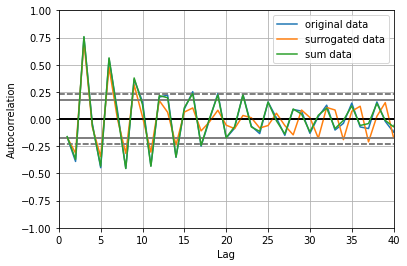

In [ ]:
import pandas as pd

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(original_data,label='original data')
y = pd.plotting.autocorrelation_plot(surrogated_data,ax=x,label='surrogated data')
y = pd.plotting.autocorrelation_plot(sum_data,ax=x,label='sum data')

# plotting the Curve
y.set_xlim(0,40)
y.plot()

[]

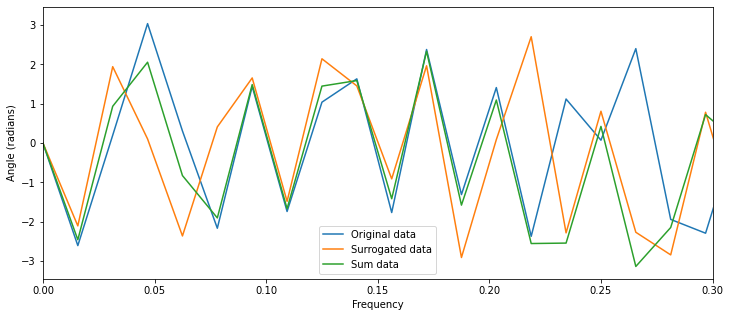

In [ ]:
fig = plt.figure(figsize=(12,5))

plt.angle_spectrum(original_data, label='Original data')
plt.angle_spectrum(surrogated_data, label='Surrogated data')
plt.angle_spectrum(sum_data,  label='Sum data')

plt.xlim(0,0.3)
plt.legend()
plt.plot()

[]

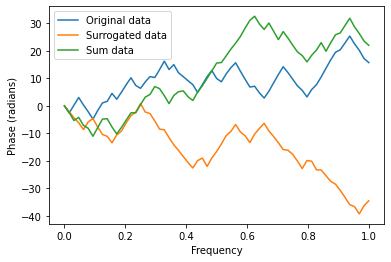

In [ ]:
plt.phase_spectrum(original_data, label='Original data')
plt.phase_spectrum(surrogated_data, label='Surrogated data')
plt.phase_spectrum(sum_data,  label='Sum data')

plt.legend()
plt.plot()

[]

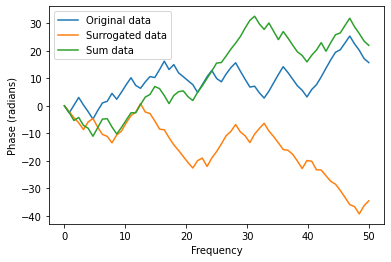

In [ ]:
spectrum_ori, phase_ori, line_ori = plt.phase_spectrum(original_data, label='Original data',Fs=100)
spectrum_surr, phase_surr, line_surr = plt.phase_spectrum(surrogated_data, label='Surrogated data',Fs=100)
spectrum_sum, phase_sum, line_sum = plt.phase_spectrum(sum_data,  label='Sum data',Fs=100)

plt.legend()
plt.plot()